## Data Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, log_loss
from scipy.stats import multivariate_normal
np.random.seed(1)


Function to generate data from a ground truth model with K classes and η-dependent covariance

In [2]:
def generate_data(n_per_class, eta, K, means, shared_cov, class_covs):
    X_list, y_list = [], []

    for i in range(K):
        cov = (1 - eta) * shared_cov + eta * class_covs[i]
        X_list.append(np.random.multivariate_normal(means[i], cov, size=n_per_class))
        y_list.append(np.full(n_per_class, i))

    X = np.vstack(X_list)
    y = np.hstack(y_list)

    rng = np.random.default_rng(seed=42)
    perm = rng.permutation(len(y))

    return X[perm], y[perm]


Base simulation setup
- Create smooth class covariance matrices with varying correlations
- Correlation smoothly varies between -1 and 1

In [3]:
def setup_simulation(K, eta, n_train, spread=6.0, print_covariances=False):
    """
    Generates well-separated classes with clear covariance differences:
    - eta = 0: All classes identical covariance → LDA optimal, QDA overfits
    - eta → 1: Classes have very different shapes → QDA better, LDA suboptimal
    """
    np.random.seed(42)
    
    # Create moderately separated, clean centroid arrangement
    means = []
    if K == 2:
        means = [np.array([-2.5, 0.0]), np.array([2.5, 0.0])]
    elif K == 3:
        # Triangle arrangement for 3 classes - closer together
        means = [
            np.array([0.0, 2.5]),      # Top
            np.array([-2.2, -1.3]),   # Bottom left  
            np.array([2.2, -1.3])     # Bottom right
        ]
    else:
        # Regular polygon for K > 3 - smaller radius
        angles = np.linspace(0, 2*np.pi, K+1)[:-1]
        radius = 3.0
        for angle in angles:
            means.append(np.array([radius * np.cos(angle), radius * np.sin(angle)]))
    
    # Shared covariance: this will be the ONLY covariance at eta=0
    shared_cov = np.array([[1.2, 0.4],
                          [0.4, 1.0]])
    
    # Class-specific covariances: extremely distinct shapes to hurt LDA more
    class_covs = []
    
    if K >= 1:
        # Class 0: Very strong horizontal elongation
        class_covs.append(np.array([[4.5, 0.0],
                                   [0.0, 0.3]]))
    
    if K >= 2:
        # Class 1: Very strong vertical elongation
        class_covs.append(np.array([[0.3, 0.0],
                                   [0.0, 4.5]]))
    
    if K >= 3:
        # Class 2: Strong positive diagonal correlation with large spread
        class_covs.append(np.array([[2.8, 2.5],
                                   [2.5, 2.8]]))
    
    if K >= 4:
        # Class 3: Very strong negative diagonal correlation
        class_covs.append(np.array([[2.8, -2.5],
                                   [-2.5, 2.8]]))
    
    if K >= 5:
        # Class 4: Extremely small, tight circular - very different scale
        class_covs.append(np.array([[0.15, 0.0],
                                   [0.0, 0.15]]))
    
    # For additional classes beyond 5, create systematic patterns
    while len(class_covs) < K:
        k = len(class_covs)
        angle = k * np.pi / 4
        cos_a, sin_a = np.cos(angle), np.sin(angle)
        rotation = np.array([[cos_a, -sin_a],
                           [sin_a, cos_a]])
        
        # Alternate between very elongated and very compact
        if k % 2 == 0:
            base_cov = np.array([[4.0, 0.0], [0.0, 0.25]])
        else:
            base_cov = np.array([[0.2, 0.0], [0.0, 0.2]])
            
        rotated_cov = rotation @ base_cov @ rotation.T
        class_covs.append(rotated_cov)
    
    # Ensure all covariances are positive definite
    for i in range(len(class_covs)):
        class_covs[i] = (class_covs[i] + class_covs[i].T) / 2 + 1e-6 * np.eye(2)
    
    if print_covariances:
        print(f"Eta = {eta}")
        print(f"Shared covariance:\n{shared_cov}\n")
        for k in range(K):
            actual_cov = (1 - eta) * shared_cov + eta * class_covs[k]
            print(f"Class {k} centroid: {means[k]}")
            print(f"Actual covariance matrix:\n{actual_cov}")
            eigvals = np.linalg.eigvals(actual_cov)
            print(f"Eigenvalues: {eigvals}")
            print(f"Condition number: {np.max(eigvals)/np.min(eigvals):.2f}\n")
    
    # Generate data
    n_per_class = max(1, n_train // K)
    X_list, y_list = [], []
    for k in range(K):
        actual_cov = (1 - eta) * shared_cov + eta * class_covs[k]
        X_k = np.random.multivariate_normal(means[k], actual_cov, size=n_per_class)
        y_k = np.full(n_per_class, k)
        X_list.append(X_k)
        y_list.append(y_k)
    
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    # Shuffle
    rng = np.random.default_rng(seed=42)
    perm = rng.permutation(len(y))
    X, y = X[perm], y[perm]
    
    return X, y, means, shared_cov, class_covs



## Models

Function to compute Bayes classifier predictions

In [4]:
def compute_bayes_predictions(X, means, shared_cov, class_covs, eta):
    K = len(means)
    n = X.shape[0]
    probs = np.zeros((n, K))
    priors = np.full(K, 1.0 / K)  # uniform priors


    for k in range(K):
        sigma_k = (1 - eta) * shared_cov + eta * class_covs[k]
        sigma_k = (sigma_k + sigma_k.T) / 2  # enforce symmetry
        sigma_k += np.eye(sigma_k.shape[0]) * 1e-6  # add epsilon for numerical stability

        rv = multivariate_normal(mean=means[k], cov=sigma_k)
        probs[:, k] = rv.pdf(X) * priors[k]

    probs /= probs.sum(axis=1, keepdims=True)
    predictions = np.argmax(probs, axis=1)
    return predictions, probs


In [5]:
import numpy as np
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def compute_lda_predictions(X_train, y_train, X_test):
    model = LinearDiscriminantAnalysis().fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    return preds, probs, model


In [6]:

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def compute_qda_predictions(X_train, y_train, X_test):
    model = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)
    return preds, probs, model



In [7]:
from sklearn.utils import shuffle

# Parameters

K = 3
eta = 1
n_train = 1000
n_test = 1000

# Generate train and test data
X_train, y_train, means, shared_cov, class_covs = setup_simulation(K, eta, n_train)
X_test, y_test, _, _, _ = setup_simulation(K, eta, n_test)

# Bayes predictions
bayes_preds, bayes_probs = compute_bayes_predictions(X_test, means, shared_cov, class_covs, eta)

# LDA predictions
lda_preds, lda_probs, lda_model = compute_lda_predictions(X_train, y_train, X_test)

# QDA predictions
qda_preds, qda_probs, qda_model = compute_qda_predictions(X_train, y_train, X_test)

# Evaluation
def evaluate(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    ll = log_loss(y_true, y_prob)
    print(f"{name} — Accuracy: {acc:.3f}, Log Loss: {ll:.3f}")

evaluate("Bayes", y_test, bayes_preds, bayes_probs)
evaluate("LDA", y_test, lda_preds, lda_probs)
evaluate("QDA", y_test, qda_preds, qda_probs)


Bayes — Accuracy: 0.948, Log Loss: 0.105
LDA — Accuracy: 0.924, Log Loss: 0.234
QDA — Accuracy: 0.950, Log Loss: 0.107


# Plot

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lda_decision_boundary(X, y, model, title="LDA Decision Boundary"):
    # Create a fine mesh grid over the input space
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict class labels over the grid
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training points
    plt.figure(figsize=(7, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Set1)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
def plot_qda_decision_boundary(X, y, model, title="QDA Decision Boundary"):
    # Create a fine mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict class labels over the grid
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    # Plot contours and training points
    plt.figure(figsize=(7, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Set1)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
def plot_bayes_decision_boundary(X, y, means, shared_cov, class_covs, eta, title="Bayes Decision Boundary"):
    from scipy.stats import multivariate_normal

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Compute class posteriors manually using true parameters
    K = len(means)
    priors = np.full(K, 1.0 / K)
    probs = np.zeros((grid.shape[0], K))

    for k in range(K):
        cov_k = (1 - eta) * shared_cov + eta * class_covs[k]
        cov_k = (cov_k + cov_k.T) / 2 + 1e-6 * np.eye(2)  # stabilize
        rv = multivariate_normal(mean=means[k], cov=cov_k)
        probs[:, k] = rv.pdf(grid) * priors[k]

    preds = np.argmax(probs, axis=1)
    Z = preds.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(7, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Set1)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Set1)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


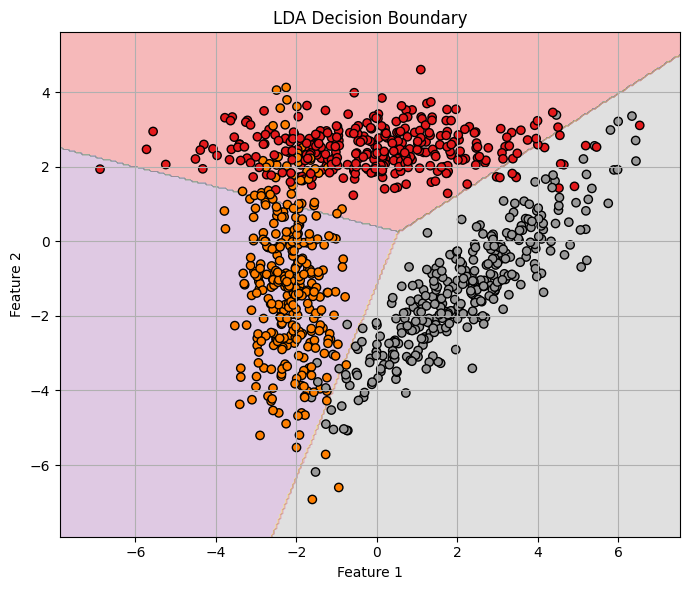

In [11]:
plot_lda_decision_boundary(X_train, y_train, lda_model)

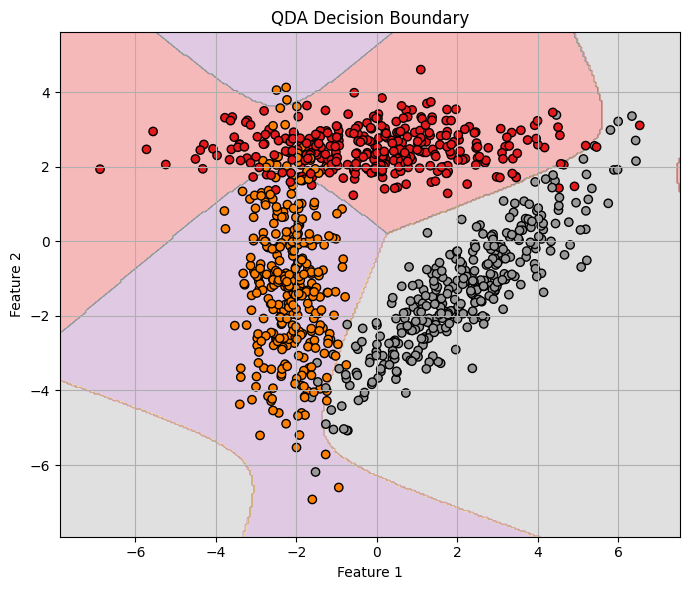

In [12]:
plot_qda_decision_boundary(X_train, y_train, qda_model)

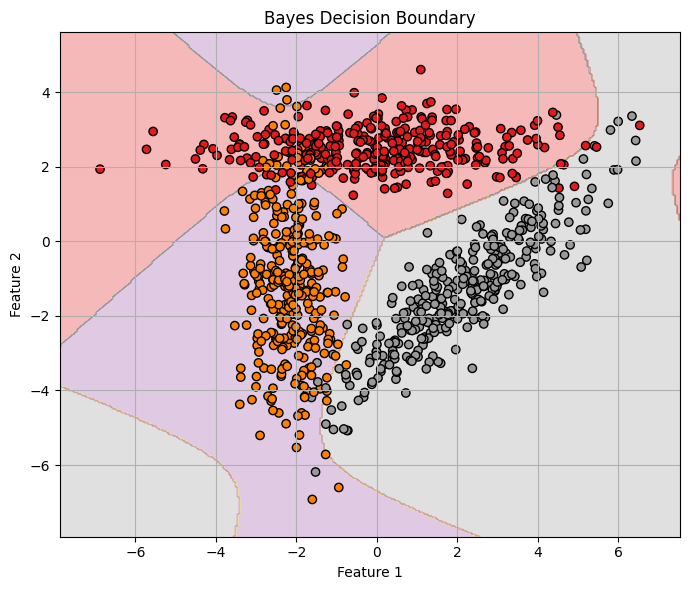

In [13]:
plot_bayes_decision_boundary(X_train, y_train, means, shared_cov, class_covs, eta)

## combined

In [14]:
def plot_combined_boundaries(X, y, lda_model, qda_model, means, shared_cov, class_covs, eta):
    from scipy.stats import multivariate_normal
    from matplotlib.colors import ListedColormap

    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict class labels
    lda_Z = lda_model.predict(grid).reshape(xx.shape)
    qda_Z = qda_model.predict(grid).reshape(xx.shape)

    # Bayes decision
    K = len(means)
    priors = np.full(K, 1.0 / K)
    probs = np.zeros((grid.shape[0], K))

    for k in range(K):
        cov_k = (1 - eta) * shared_cov + eta * class_covs[k]
        cov_k = (cov_k + cov_k.T) / 2 + 1e-6 * np.eye(2)
        rv = multivariate_normal(mean=means[k], cov=cov_k)
        probs[:, k] = rv.pdf(grid) * priors[k]
    bayes_Z = np.argmax(probs, axis=1).reshape(xx.shape)

    # Plot
    plt.figure(figsize=(8, 6))

    # Background colours: soft red, blue, green
    background_cmap = ListedColormap(['#ffe6e6', '#e6f0ff', '#e6ffe6'])
    plt.contourf(xx, yy, bayes_Z, alpha=0.8, cmap=background_cmap)

    # Overlay contour lines (decision boundaries)
    plt.contour(xx, yy, bayes_Z, colors='grey', linestyles='-', linewidths=2)
    plt.contour(xx, yy, lda_Z, colors='orange', linestyles='--', linewidths=1.5)
    plt.contour(xx, yy, qda_Z, colors='purple', linestyles='-.', linewidths=1.5)


    # Scatter data points: red, blue, green
    colors_points = np.array(['red', 'blue', 'green'])
    plt.scatter(X[:, 0], X[:, 1], c=colors_points[y], edgecolor='k', s=40)

    # Labels and legend
    plt.title("LDA vs QDA vs Bayes ($\\Sigma_1$ = $\\Sigma_2$ = $\\Sigma_3$)")
    #plt.title("LDA vs QDA vs Bayes ($\\Sigma_1$ ≠ $\\Sigma_2$ ≠ $\\Sigma_3$)")
    plt.xlabel("X 1")
    plt.ylabel("X 2")
    plt.grid(True)
    plt.tight_layout()

    custom_lines = [
        plt.Line2D([0], [0], color='grey', lw=2, label='Bayes'),
        plt.Line2D([0], [0], color='orange', linestyle='--', lw=1.5, label='LDA'), 
        plt.Line2D([0], [0], color='purple', linestyle='-.', lw=1.5, label='QDA')
        ]   
    plt.legend(handles=custom_lines)
    plt.show()


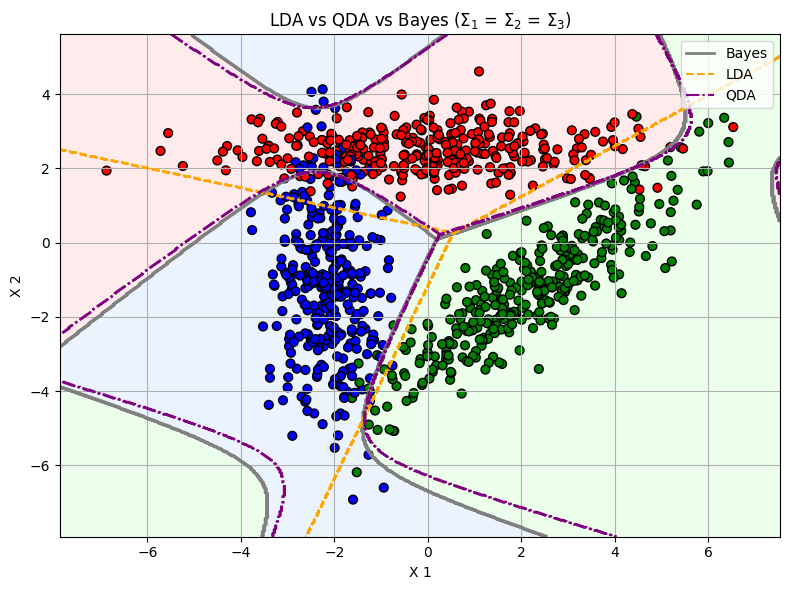

In [15]:
plot_combined_boundaries(X_train, y_train, lda_model, qda_model, means, shared_cov, class_covs, eta)